# 04 - Train Model

In [72]:
# Standard library imports
import os
import warnings
import joblib

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt

from datetime import datetime

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Bidirectional, Flatten, Attention
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Disable GPU usage (if not using GPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Suppress all TensorFlow logs and CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show errors
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")

# Set TensorFlow log level to ERROR (to suppress info and warnings)
tf.get_logger().setLevel('ERROR')

# Notebook settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
data = pd.read_csv(os.path.join('..','data','processed','data_for_model.csv'))

print(data.shape)

data.head()

(7429, 95)


,home_team,away_team,full_time_result,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,home_roll_3_avg_home_total_goals,away_roll_3_avg_home_total_goals,home_roll_3_avg_away_total_goals,away_roll_3_avg_away_total_goals,home_roll_3_avg_home_total_shots,away_roll_3_avg_home_total_shots,home_roll_3_avg_away_total_shots,away_roll_3_avg_away_total_shots,home_roll_3_avg_home_shots_on_target,away_roll_3_avg_home_shots_on_target,home_roll_3_avg_away_shots_on_target,away_roll_3_avg_away_shots_on_target,home_roll_3_avg_home_fouls,away_roll_3_avg_home_fouls,home_roll_3_avg_away_fouls,away_roll_3_avg_away_fouls,home_roll_3_avg_home_corners,away_roll_3_avg_home_corners,home_roll_3_avg_away_corners,away_roll_3_avg_away_corners,home_roll_3_avg_home_yellow_cards,away_roll_3_avg_home_yellow_cards,home_roll_3_avg_away_yellow_cards,away_roll_3_avg_away_yellow_cards,home_roll_3_avg_home_red_cards,away_roll_3_avg_home_red_cards,home_roll_3_avg_away_red_cards,away_roll_3_avg_away_red_cards,home_roll_3_avg_home_shot_accuracy,away_roll_3_avg_home_shot_accuracy,home_roll_3_avg_away_shot_accuracy,away_roll_3_avg_away_shot_accuracy,home_roll_3_avg_ratio_h_a_shots,away_roll_3_avg_ratio_h_a_shots,home_roll_3_avg_ratio_h_a_fouls,away_roll_3_avg_ratio_h_a_fouls,home_roll_3_avg_ratio_a_h_shots,away_roll_3_avg_ratio_a_h_shots,home_roll_3_avg_ratio_a_h_fouls,away_roll_3_avg_ratio_a_h_fouls,home_roll_3_avg_goal_difference,away_roll_3_avg_goal_difference,home_roll_5_avg_home_total_goals,away_roll_5_avg_home_total_goals,home_roll_5_avg_away_total_goals,away_roll_5_avg_away_total_goals,home_roll_5_avg_home_total_shots,away_roll_5_avg_home_total_shots,home_roll_5_avg_away_total_shots,away_roll_5_avg_away_total_shots,home_roll_5_avg_home_shots_on_target,away_roll_5_avg_home_shots_on_target,home_roll_5_avg_away_shots_on_target,away_roll_5_avg_away_shots_on_target,home_roll_5_avg_home_fouls,away_roll_5_avg_home_fouls,home_roll_5_avg_away_fouls,away_roll_5_avg_away_fouls,home_roll_5_avg_home_corners,away_roll_5_avg_home_corners,home_roll_5_avg_away_corners,away_roll_5_avg_away_corners,home_roll_5_avg_home_yellow_cards,away_roll_5_avg_home_yellow_cards,home_roll_5_avg_away_yellow_cards,away_roll_5_avg_away_yellow_cards,home_roll_5_avg_home_red_cards,away_roll_5_avg_home_red_cards,home_roll_5_avg_away_red_cards,away_roll_5_avg_away_red_cards,home_roll_5_avg_home_shot_accuracy,away_roll_5_avg_home_shot_accuracy,home_roll_5_avg_away_shot_accuracy,away_roll_5_avg_away_shot_accuracy,home_roll_5_avg_ratio_h_a_shots,away_roll_5_avg_ratio_h_a_shots,home_roll_5_avg_ratio_h_a_fouls,away_roll_5_avg_ratio_h_a_fouls,home_roll_5_avg_ratio_a_h_shots,away_roll_5_avg_ratio_a_h_shots,home_roll_5_avg_ratio_a_h_fouls,away_roll_5_avg_ratio_a_h_fouls,home_roll_5_avg_goal_difference,away_roll_5_avg_goal_difference,home_cumulative_points,away_cumulative_points
0,aston villa,bolton,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,everton,man united,A,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
2,fulham,birmingham,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [3]:
print(data.shape)
data.columns

(7429, 95)


Index(['home_team', 'away_team', 'full_time_result', 'day_of_week', 'month',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'home_roll_3_avg_home_total_goals', 'away_roll_3_avg_home_total_goals',
       'home_roll_3_avg_away_total_goals', 'away_roll_3_avg_away_total_goals',
       'home_roll_3_avg_home_total_shots', 'away_roll_3_avg_home_total_shots',
       'home_roll_3_avg_away_total_shots', 'away_roll_3_avg_away_total_shots',
       'home_roll_3_avg_home_shots_on_target',
       'away_roll_3_avg_home_shots_on_target',
       'home_roll_3_avg_away_shots_on_target',
       'away_roll_3_avg_away_shots_on_target', 'home_roll_3_avg_home_fouls',
       'away_roll_3_avg_home_fouls', 'home_roll_3_avg_away_fouls',
       'away_roll_3_avg_away_fouls', 'home_roll_3_avg_home_corners',
       'away_roll_3_avg_home_corners', 'home_roll_3_avg_away_corners',
       'away_roll_3_avg_away_corners', 'home_roll_3_avg_home_yellow_cards',
       'away_roll_3_avg_home_yellow

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7429 entries, 0 to 7428
Data columns (total 95 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   home_team                             7429 non-null   object 
 1   away_team                             7429 non-null   object 
 2   full_time_result                      7429 non-null   object 
 3   day_of_week                           7429 non-null   int64  
 4   month                                 7429 non-null   int64  
 5   day_of_week_sin                       7429 non-null   float64
 6   day_of_week_cos                       7429 non-null   float64
 7   month_sin                             7429 non-null   float64
 8   month_cos                             7429 non-null   float64
 9   home_roll_3_avg_home_total_goals      7429 non-null   float64
 10  away_roll_3_avg_home_total_goals      7429 non-null   float64
 11  home_roll_3_avg_a

In [5]:
# define X and y
X = data.drop(columns=['full_time_result'])
y = data['full_time_result']

In [6]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5943, 94), (1486, 94), (5943,), (1486,))

In [7]:
def plot_training_history(history, name):
    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss ({name})')  # Title with model name
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy ({name})')  # Title with model name
    plt.legend()

    plt.tight_layout()

    # Ensure the directory exists
    os.makedirs(os.path.join('..', 'images'), exist_ok=True)
    
    # Save the plot with the name as part of the filename
    plt.savefig(os.path.join('..','images', name + '.png'))
    
    plt.show()


## Preprocess Data

In [73]:
def preprocess_data(X, y):
    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.drop(columns=categorical_features).columns.tolist()
    
    # Save feature lists for consistency in prediction
    feature_info = {
        'categorical_features': categorical_features,
        'numerical_features': numerical_features
    }
    
    # Preprocess categorical and numerical features
    ct = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])
    X_processed = ct.fit_transform(X)
    
    # Encode target variable ('H', 'D', 'A')
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)  # Converts 'H', 'D', 'A' to 0, 1, 2
    y_categorical = to_categorical(y_encoded)  # One-hot encoding
    
    return X_processed, y_categorical, ct, label_encoder, feature_info

# Preprocess the data
X_train_processed, y_train_processed, ct, label_encoder, feature_info = preprocess_data(X_train, y_train)
X_test_processed = ct.transform(X_test)
y_test_encoded = label_encoder.transform(y_test)
y_test_processed = to_categorical(y_test_encoded)

# save feature_info for prediction
np.save(os.path.join('..','models','feature_info.npy'), feature_info)

# Save the ColumnTransformer
joblib.dump(ct, os.path.join('..', 'models', 'column_transformer.pkl'))

# Save the LabelEncoder
joblib.dump(label_encoder, os.path.join('..', 'models', 'label_encoder.pkl'))

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))  # Convert to dict for Keras

# Model Testing

In [9]:
# Define a learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 10:
        return float(lr)  # Ensuring that the returned value is a plain float
    else:
        # Use exponential decay to reduce the learning rate
        new_lr = float(lr * tf.math.exp(-0.1))  # Convert Tensor to Python float
        return new_lr
    
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

## Dense Model

In [10]:
# Build the refined Dense Model
model_dense = Sequential([
    Input(shape=(X_train_processed.shape[1],)),
    Dense(128, activation='swish', kernel_regularizer=l2(0.005)),  # Changed activation to 'swish' and regularization strength
    Dropout(0.4),
    Dense(64, activation='swish', kernel_regularizer=l2(0.005)),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

# Compile the model with adjusted learning rate scheduler
optimizer = Adam(learning_rate=0.001)
model_dense.compile(optimizer=optimizer,
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Train the refined model with the fixed learning rate scheduler
history_dense = model_dense.fit(X_train_processed, y_train_processed,
                                                  epochs=100,
                                                  batch_size=32,
                                                  validation_split=0.2,
                                                  verbose=1,
                                                  class_weight=class_weights,
                                                  callbacks=[early_stopping, LearningRateScheduler(lr_schedule)])

# Evaluate the refined model
test_loss_dense, test_accuracy_dense = model_dense.evaluate(X_test_processed, y_test_processed)
print(f"Dense Model Test Accuracy: {test_accuracy_dense:.2f}")

Epoch 1/100


2025-01-19 16:37:01.440641: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4150 - loss: 2.1114 - val_accuracy: 0.4828 - val_loss: 1.6417 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4757 - loss: 1.5810 - val_accuracy: 0.5374 - val_loss: 1.3797 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.5210 - loss: 1.3515 - val_accuracy: 0.5837 - val_loss: 1.2345 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ -315s -2128464us/step - accuracy: 0.5444 - loss: 1.2319 - val_accuracy: 0.6156 - val_loss: 1.1294 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5739 - loss: 1.1222 - val_accuracy: 0.6030 - val_loss: 1.0642 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5926 - loss: 1.0574 - val_accuracy: 0.5601 - val_loss: 1.0517 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5748 - loss: 1.0

In [11]:
# save the model
path_to_save_model = os.path.join('..','models','model_dense.keras')

model_dense.save(path_to_save_model)

# how many MB the model is
os.path.getsize(path_to_save_model) / (1024 * 1024)  # in MB

0.3786811828613281

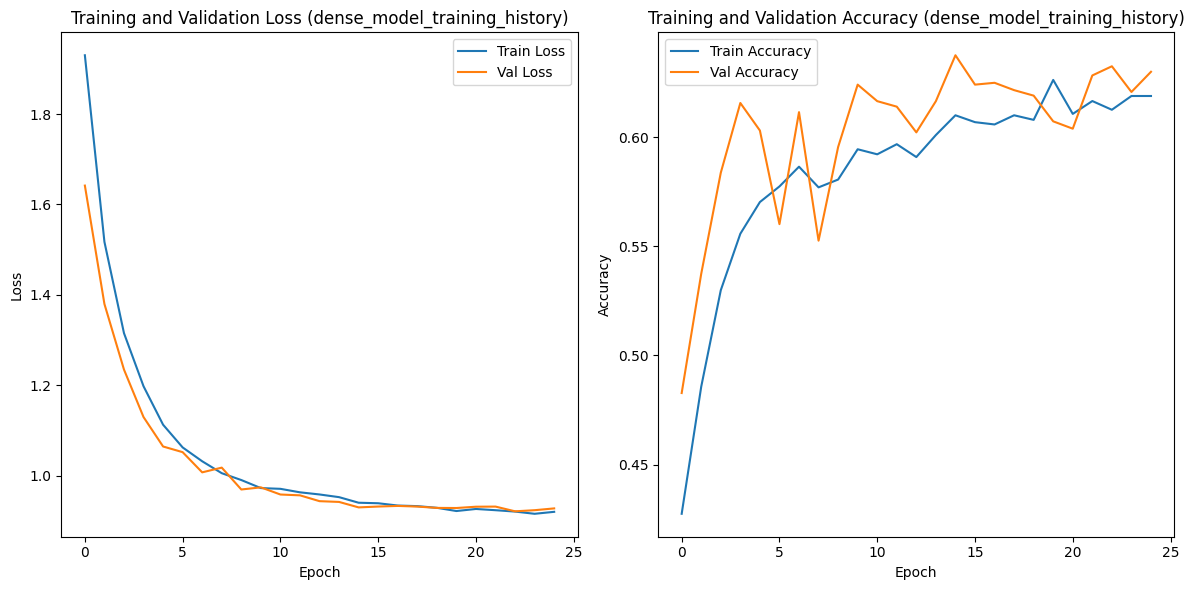

In [12]:
# Call the function to plot the training history
plot_training_history(history_dense, name='dense_model_training_history')

## Convolutional Neural Network (CNN)

In [13]:
model_cnn = Sequential([
    Input(shape=(X_train_processed.shape[1], 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Smaller filters
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Smaller filters
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile the refined CNN model
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Train the refined CNN model
history_cnn = model_cnn.fit(X_train_processed[..., np.newaxis],
                                              y_train_processed,
                                              epochs=100,
                                              batch_size=32,
                                              validation_split=0.2,
                                              class_weight=class_weights,
                                              callbacks=[early_stopping, LearningRateScheduler(lr_schedule)])

# Evaluate the refined CNN model
cnn_test_loss, cnn_test_accuracy = model_cnn.evaluate(X_test_processed[..., np.newaxis], y_test_processed)
print(f"CNN Model Test Accuracy: {cnn_test_accuracy:.2f}")

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3507 - loss: 1.3339 - val_accuracy: 0.2271 - val_loss: 1.4560 - learning_rate: 0.0010
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3657 - loss: 1.2843 - val_accuracy: 0.2271 - val_loss: 1.3388 - learning_rate: 0.0010
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3511 - loss: 1.2504 - val_accuracy: 0.2675 - val_loss: 1.2487 - learning_rate: 0.0010
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3839 - loss: 1.2097 - val_accuracy: 0.3759 - val_loss: 1.1986 - learning_rate: 0.0010
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3963 - loss: 1.1877 - val_accuracy: 0.3541 - val_loss: 1.1804 - learning_rate: 0.0010
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3984 - loss: 1.1732 - val_accuracy: 0.3759 - val_loss: 1.1876 - learning_rate: 0.0010
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3679 - l

In [14]:
# save the model
path_to_save_model_cnn = os.path.join('..','models','model_cnn.keras')

model_cnn.save(path_to_save_model_cnn)

# how many MB the model is
os.path.getsize(path_to_save_model_cnn) / (1024 * 1024)  # in MB

0.538665771484375

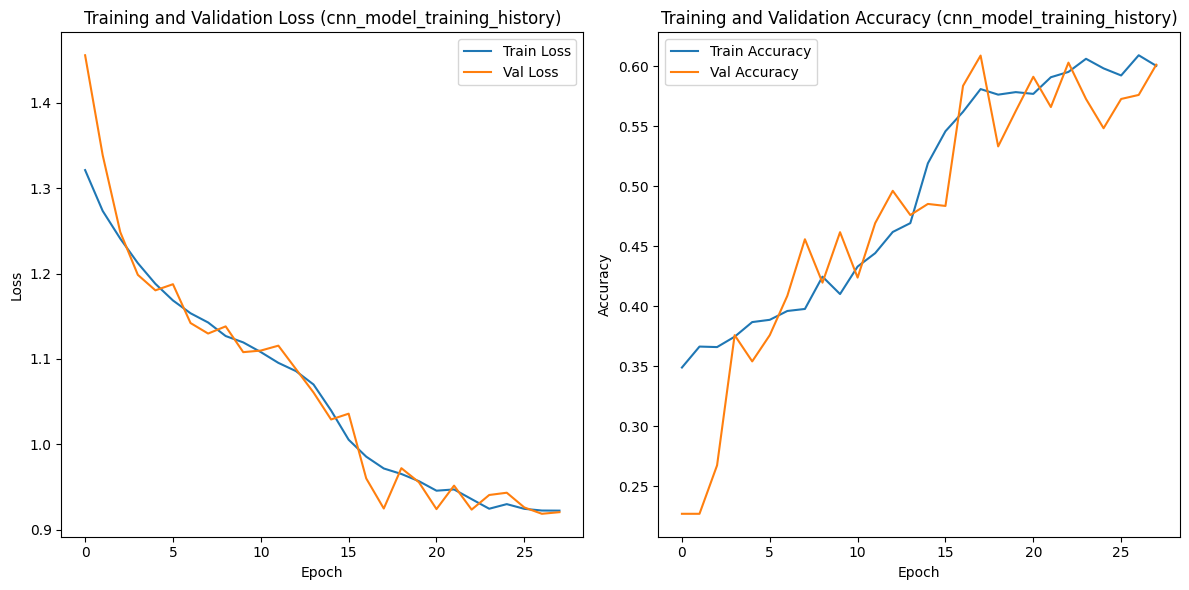

In [15]:
plot_training_history(history_cnn, name='cnn_model_training_history')

## Long Short-Term Memory (LSTM)

In [16]:
sequence_length = 5  # Fixed length for sequences

# Determine the number of sequences
num_sequences_train = X_train_processed.shape[0] // sequence_length
num_sequences_test = X_test_processed.shape[0] // sequence_length

# Reshape inputs into sequences
X_train_seq = X_train_processed[:num_sequences_train * sequence_length].reshape((-1, sequence_length, X_train_processed.shape[1]))
X_test_seq = X_test_processed[:num_sequences_test * sequence_length].reshape((-1, sequence_length, X_test_processed.shape[1]))

# Use the label of the last element in each sequence as the label for that sequence
y_train_seq = y_train_processed[sequence_length - 1::sequence_length][:num_sequences_train]
y_test_seq = y_test_processed[sequence_length - 1::sequence_length][:num_sequences_test]

# Debugging: Check shapes after adjustment
print(f"X_train_seq shape: {X_train_seq.shape}")  # Should be (num_sequences_train, sequence_length, num_features)
print(f"y_train_seq shape: {y_train_seq.shape}")  # Should be (num_sequences_train, num_classes)
print(f"X_test_seq shape: {X_test_seq.shape}")    # Should be (num_sequences_test, sequence_length, num_features)
print(f"y_test_seq shape: {y_test_seq.shape}")    # Should be (num_sequences_test, num_classes)

# Simplified LSTM Model
model_lstm = Sequential([
    Input(shape=(sequence_length, X_train_seq.shape[2])),  # Input shape should match the reshaped data
    Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.005))),  # Reduced units and regularization
    BatchNormalization(),
    Dropout(0.3),  # Lower dropout rate
    Dense(64, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Output layer for 3 classes (H, D, A)
])

model_lstm.compile(optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train the simplified model
history_lstm = model_lstm.fit(
    X_train_seq,
    y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,  # Balanced class weights
    callbacks=[early_stopping, LearningRateScheduler(lr_schedule)]
)

# Evaluate the model
lstm_test_loss, lstm_test_accuracy = model_lstm.evaluate(X_test_seq, y_test_seq)
print(f"LSTM Test Accuracy: {lstm_test_accuracy:.2f}")

X_train_seq shape: (1188, 5, 172)
y_train_seq shape: (1188, 3)
X_test_seq shape: (297, 5, 172)
y_test_seq shape: (297, 3)
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4089 - loss: 3.9767 - val_accuracy: 0.3025 - val_loss: 3.3567 - learning_rate: 5.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3939 - loss: 3.5486 - val_accuracy: 0.2983 - val_loss: 3.1585 - learning_rate: 5.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3981 - loss: 3.2712 - val_accuracy: 0.3109 - val_loss: 2.9759 - learning_rate: 5.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4105 - loss: 3.0990 - val_accuracy: 0.3277 - val_loss: 2.8281 - learning_rate: 5.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3914 - loss: 2.9031 - val_accuracy: 0.3571 - val_loss: 2.6985 - learning_rate: 5.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4395 - loss: 2.6893 - val_accuracy: 0

In [17]:
# save the model
path_to_save_model_lstm = os.path.join('..','models','model_lstm.keras')

model_lstm.save(path_to_save_model_lstm)

# how many MB the model is
os.path.getsize(path_to_save_model_lstm) / (1024 * 1024)  # in MB

1.5371074676513672

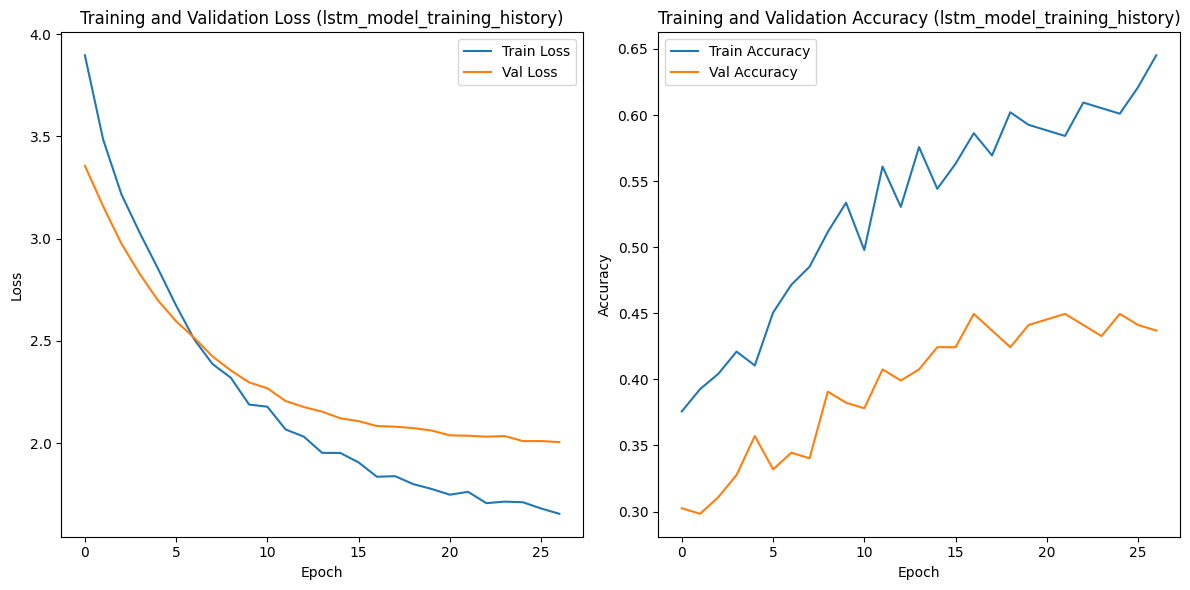

In [18]:
plot_training_history(history_lstm, name='lstm_model_training_history')

## Temporal Convolutional Networks (TCNs)

In [19]:
# Model with Convolutional Layers (Temporal Convolutions)
model_tcn = Sequential([
    Input(shape=(sequence_length, X_train_seq.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes for H, D, A
])

model_tcn.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the TCN model
history_tcn = model_tcn.fit(
    X_train_seq,
    y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, LearningRateScheduler(lr_schedule)]
)

# Evaluate the model
tcn_test_loss, tcn_test_accuracy = model_tcn.evaluate(X_test_seq, y_test_seq)
print(f"TCN Test Accuracy: {tcn_test_accuracy:.2f}")

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2997 - loss: 1.1557 - val_accuracy: 0.3361 - val_loss: 1.1001 - learning_rate: 5.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4354 - loss: 1.0637 - val_accuracy: 0.2773 - val_loss: 1.1239 - learning_rate: 5.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4830 - loss: 1.0238 - val_accuracy: 0.3529 - val_loss: 1.0982 - learning_rate: 5.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5297 - loss: 0.9599 - val_accuracy: 0.3277 - val_loss: 1.1418 - learning_rate: 5.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 316s 11s/step - accuracy: 0.5361 - loss: 0.9413 - val_accuracy: 0.3782 - val_loss: 1.0986 - learning_rate: 5.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ -315s -10868517us/step - accuracy: 0.6380 - loss: 0.8230 - val_accuracy: 0.4286 - val_loss: 1.0880 - learning_rate: 5.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

In [20]:
# save the model
path_to_save_model_tcn = os.path.join('..','models','model_tcn.keras')

model_tcn.save(path_to_save_model_tcn)

# how many MB the model is
os.path.getsize(path_to_save_model_tcn) / (1024 * 1024)  # in MB

0.8924236297607422

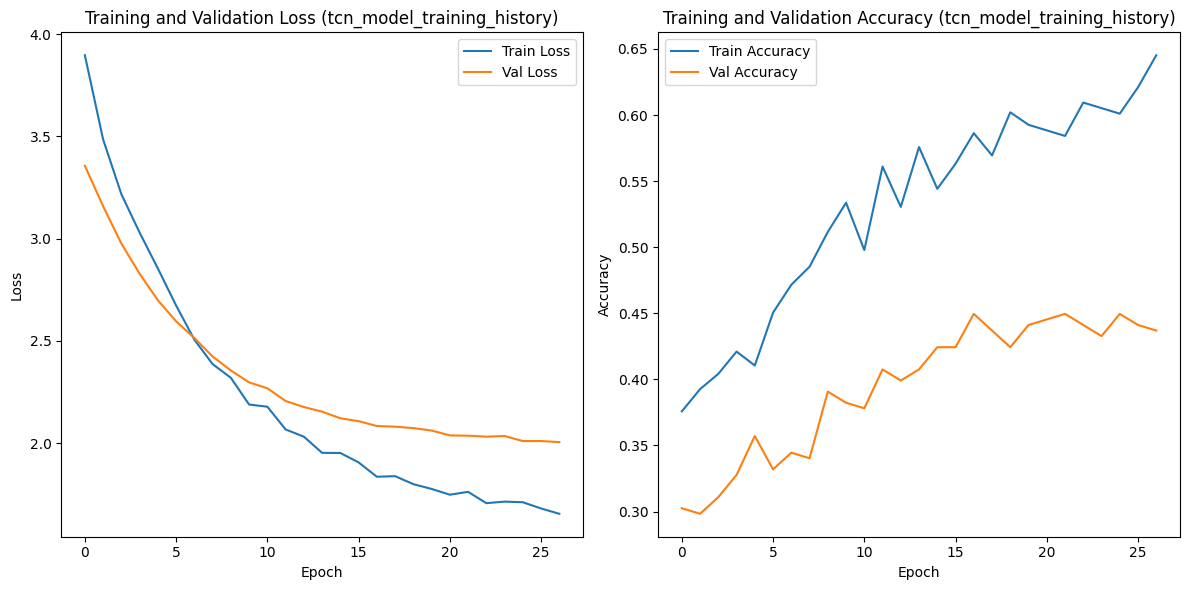

In [21]:
plot_training_history(history_lstm, name='tcn_model_training_history')

## Attention Mechanisms

In [22]:
# LSTM Model with Attention Mechanism
inputs = Input(shape=(sequence_length, X_train_seq.shape[2]))  # Define input layer

# Bidirectional LSTM layer
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(inputs)

# Attention mechanism: Using the same LSTM output for query and value
attention_out = Attention()([lstm_out, lstm_out])

# Flatten the output of Attention layer
flatten_out = Flatten()(attention_out)

# Dense layers after attention mechanism
dense_out = Dense(64, activation='relu')(flatten_out)
dropout_out = Dropout(0.3)(dense_out)
output = Dense(3, activation='softmax')(dropout_out)  # Output layer with 3 classes (H, D, A)

# Build and compile the model
model_lstm_attention = Model(inputs=inputs, outputs=output)

model_lstm_attention.compile(optimizer=Adam(learning_rate=0.0005),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Train the model
history_lstm_attention = model_lstm_attention.fit(
    X_train_seq,
    y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, LearningRateScheduler(lr_schedule)]
)

# Evaluate the model
lstm_attention_test_loss, lstm_attention_test_accuracy = model_lstm_attention.evaluate(X_test_seq, y_test_seq)
print(f"LSTM + Attention Test Accuracy: {lstm_attention_test_accuracy:.2f}")

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3005 - loss: 1.1349 - val_accuracy: 0.3361 - val_loss: 1.1298 - learning_rate: 5.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4182 - loss: 1.0740 - val_accuracy: 0.3235 - val_loss: 1.1486 - learning_rate: 5.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4179 - loss: 1.0397 - val_accuracy: 0.3487 - val_loss: 1.1395 - learning_rate: 5.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4974 - loss: 0.9941 - val_accuracy: 0.3866 - val_loss: 1.1161 - learning_rate: 5.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5301 - loss: 0.9810 - val_accuracy: 0.3739 - val_loss: 1.1512 - learning_rate: 5.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5632 - loss: 0.9381 - val_accuracy: 0.3824 - val_loss: 1.1576 - learning_rate: 5.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6130

In [23]:
# save the model
path_to_save_model_lstm_attention = os.path.join('..','models','model_lstm_attention.keras')

model_lstm_attention.save(path_to_save_model_lstm_attention)

# how many MB the model is
os.path.getsize(path_to_save_model_lstm_attention) / (1024 * 1024)  # in MB

1.9076166152954102

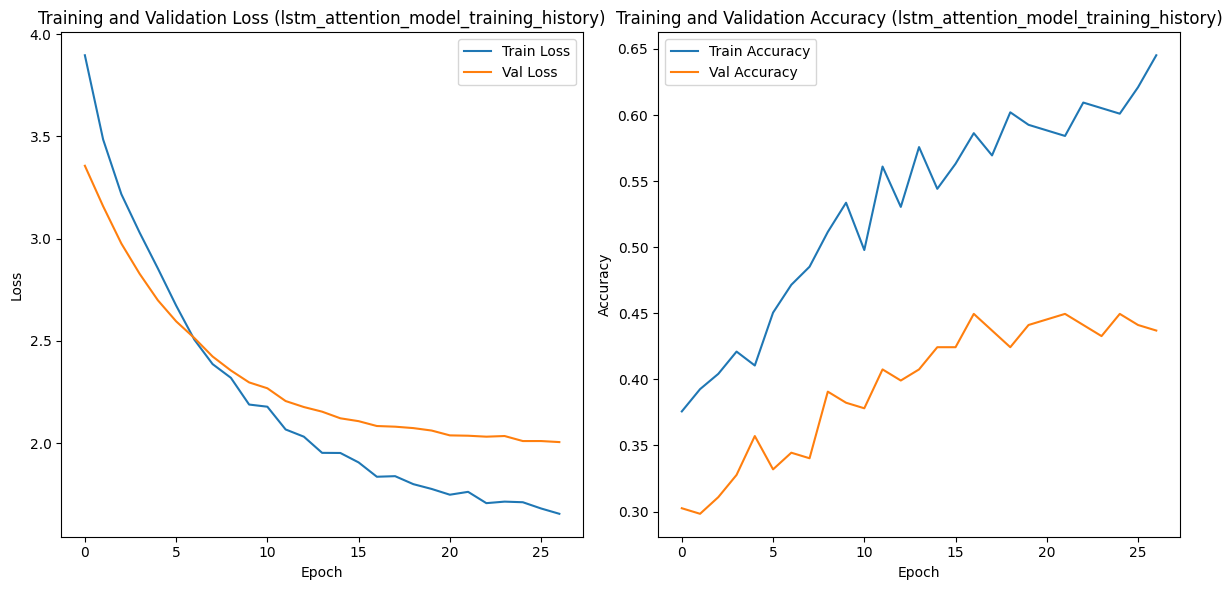

In [24]:
plot_training_history(history_lstm, name='lstm_attention_model_training_history')

# Results from all Models

Dense Model Test Accuracy: 0.62
CNN Model Test Accuracy: 0.63
LSTM Test Accuracy: 0.41
TCN Test Accuracy: 0.43
LSTM + Attention Test Accuracy: 0.42
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


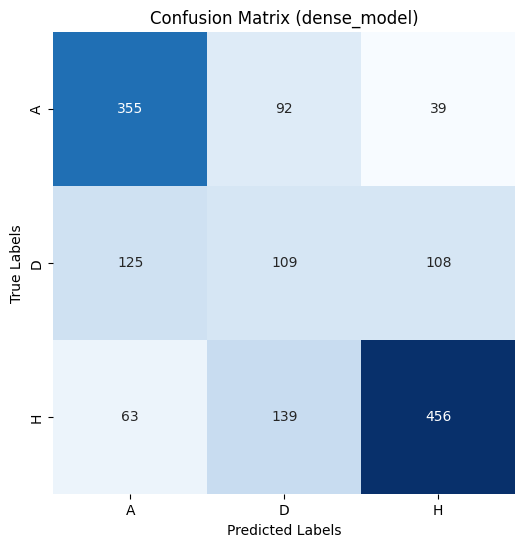

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


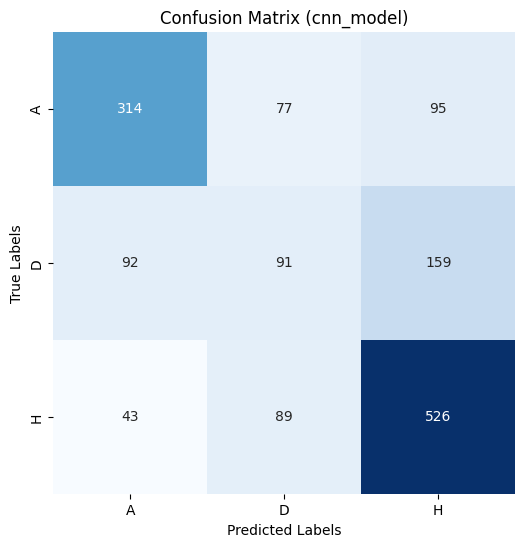

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


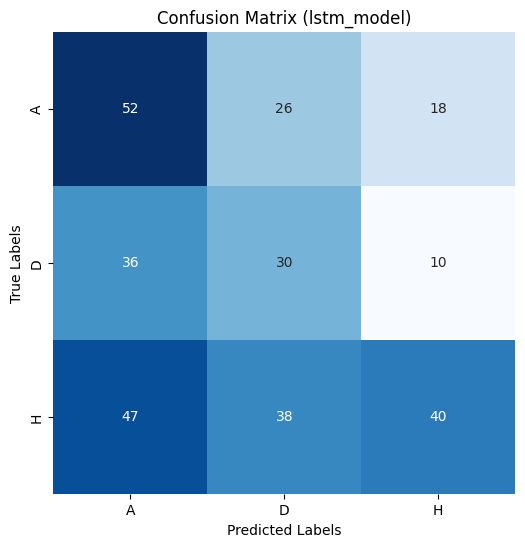

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


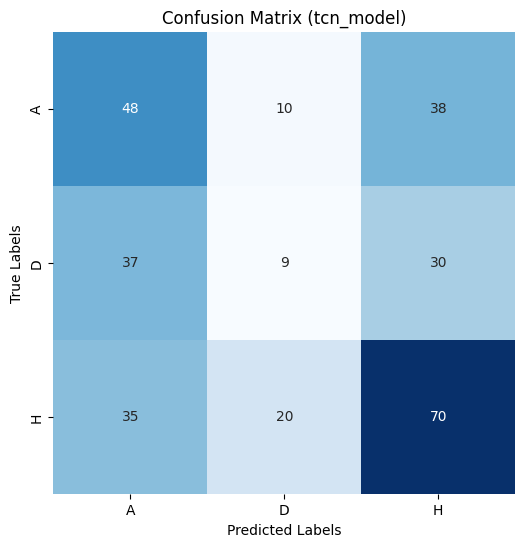

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


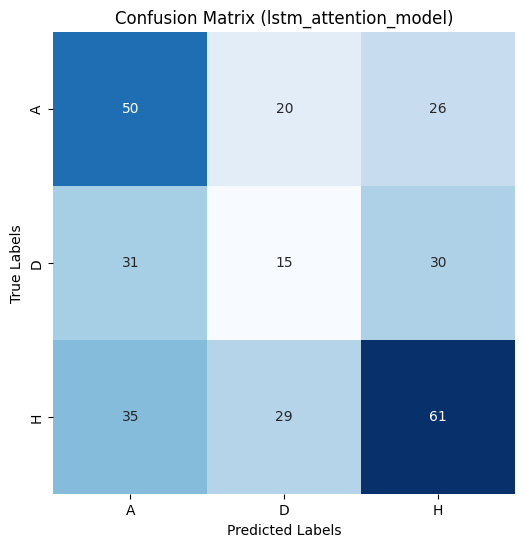

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Classification Report (dense_model):
              precision    recall  f1-score   support

           A       0.65      0.73      0.69       486
           D       0.32      0.32      0.32       342
           H       0.76      0.69      0.72       658

    accuracy                           0.62      1486
   macro avg       0.58      0.58      0.58      1486
weighted avg       0.62      0.62      0.62      1486


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report (cnn_model):
              precision    recall  f1-score   support

           A       0.70      0.65      0.67       486
           D       0.35      0.27      0.30       342
           H       0.67      0.80      0.73       658

    accuracy                           0.63      1486
   macro avg       0.58      0.57      0.57      1486
weighted avg       0.61      0.63      0.61      1486


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report (lstm_model):
         

In [25]:
# Define label names
label_names = label_encoder.classes_

# accuracy scores for all models
print(f"Dense Model Test Accuracy: {test_accuracy_dense:.2f}")
print(f"CNN Model Test Accuracy: {cnn_test_accuracy:.2f}")
print(f"LSTM Test Accuracy: {lstm_test_accuracy:.2f}")
print(f"TCN Test Accuracy: {tcn_test_accuracy:.2f}")
print(f"LSTM + Attention Test Accuracy: {lstm_attention_test_accuracy:.2f}")

# confusion matrix for all models
def plot_confusion_matrix(model, X_test, y_test, name):
    # Predict the classes using the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Convert one-hot encoded y_test to integers
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Compute the confusion matrix
    confusion = confusion_matrix(y_test_classes, y_pred_classes)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix ({name})')  # Title with model name
    
    # Ensure the directory exists
    os.makedirs(os.path.join('..', 'images'), exist_ok=True)
    
    # Save the plot with the name as part of the filename
    plt.savefig(os.path.join('..','images', name + '_confusion_matrix.png'))
    
    plt.show()
    
# Plot confusion matrix for all models
plot_confusion_matrix(model_dense, X_test_processed, y_test_processed, name='dense_model')
plot_confusion_matrix(model_cnn, X_test_processed[..., np.newaxis], y_test_processed, name='cnn_model')
plot_confusion_matrix(model_lstm, X_test_seq, y_test_seq, name='lstm_model')
plot_confusion_matrix(model_tcn, X_test_seq, y_test_seq, name='tcn_model')
plot_confusion_matrix(model_lstm_attention, X_test_seq, y_test_seq, name='lstm_attention_model')

# classification report for all models
def print_classification_report(model, X_test, y_test, name):
    # Predict the classes using the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Convert one-hot encoded y_test to integers
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Generate and print the classification report
    report = classification_report(y_test_classes, y_pred_classes, target_names=label_names)
    print(f"Classification Report ({name}):\n{report}\n")
    
# Print classification report for all models
print_classification_report(model_dense, X_test_processed, y_test_processed, name='dense_model')
print_classification_report(model_cnn, X_test_processed[..., np.newaxis], y_test_processed, name='cnn_model')
print_classification_report(model_lstm, X_test_seq, y_test_seq, name='lstm_model')
print_classification_report(model_tcn, X_test_seq, y_test_seq, name='tcn_model')
print_classification_report(model_lstm_attention, X_test_seq, y_test_seq, name='lstm_attention_model')

# Hyperparameter Tuning - Best Model

In [26]:
def build_model(hp):
    model = Sequential([  
        Input(shape=(X_train_processed.shape[1],)),  # Input layer
        Dense(
            hp.Int('units_1', min_value=128, max_value=256, step=64),  # Adjusted range for units
            activation=hp.Choice('activation_1', values=['relu', 'swish']),
            kernel_regularizer=l2(hp.Float('l2_1', min_value=0.001, max_value=0.01, step=0.001))  # Regularization
        ),
        Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.6, step=0.1)),  # Dropout
        
        Dense(
            hp.Int('units_2', min_value=128, max_value=256, step=64),  # Adjusted range for units in 2nd layer
            activation=hp.Choice('activation_2', values=['relu', 'swish']),
            kernel_regularizer=l2(hp.Float('l2_2', min_value=0.001, max_value=0.01, step=0.001))  # Regularization
        ),
        Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.6, step=0.1)),  # Dropout
        
        Dense(3, activation='softmax')  # Output layer
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Early stopping monitoring 'val_accuracy'
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)  # Reduced patience

# TensorBoard callback for logging
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")  # Unique log directory for each run
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# ModelCheckpoint callback to save the best model during training
checkpoint_callback = ModelCheckpoint(os.path('..','models','model_checkpoint.keras'), save_best_only=True)

# Perform search
def search_with_callbacks(tuner, X_train, y_train):
    tuner.search(
        X_train, y_train,
        epochs=20,  # Match this with the max_epochs in Hyperband
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weights,  # Ensure this is defined
        callbacks=[early_stopping, tensorboard_callback, checkpoint_callback]  # Include ModelCheckpoint callback
    )

# Set up the tuner with Hyperband
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,  # Reduced epochs for faster search
    factor=3,
    executions_per_trial=2,  # Reduced executions per trial for speed
    directory='tuner_dir',
    project_name='dense_model_tuning'
)

# Start the hyperparameter search
search_with_callbacks(tuner, X_train_processed, y_train_processed)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(X_test_processed, y_test_processed)
print(f"Best Model Test Accuracy: {test_accuracy:.2f}")

Trial 30 Complete [00h 00m 28s]
val_accuracy: 0.6379310190677643

Best val_accuracy So Far: 0.6379310190677643
Total elapsed time: 00h 05m 47s
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6238 - loss: 0.9426 
Best Model Test Accuracy: 0.63


In [27]:
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best Hyperparameters: {best_hyperparameters.values}")

Best Hyperparameters: {'units_1': 256, 'activation_1': 'relu', 'l2_1': 0.008, 'dropout_1': 0.4, 'units_2': 192, 'activation_2': 'relu', 'l2_2': 0.003, 'dropout_2': 0.5, 'learning_rate': 0.0009530962215570689, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [28]:
best_params_dict = {
    'units_1': 256, 
    'activation_1': 'relu', 
    'l2_1': 0.008, 
    'dropout_1': 0.4, 
    'units_2': 192, 
    'activation_2': 'relu', 
    'l2_2': 0.003, 
    'dropout_2': 0.5, 
    'learning_rate': 0.0009530962215570689, 
    'tuner/epochs': 20, 
    'tuner/initial_epoch': 0, 
    'tuner/bracket': 0, 
    'tuner/round': 0
    }

In [31]:
# save the best model
path_to_save_best_model = os.path.join('..','models','best_model.keras')

best_model.save(path_to_save_best_model)

# how many MB the model is
os.path.getsize(path_to_save_best_model) / (1024 * 1024)  # in MB

0.38434314727783203

In [35]:
# compare best model with dense model
print(f"Best Model Test Accuracy: {test_accuracy:.2f}")
print(f"Dense Model Test Accuracy: {test_accuracy_dense:.2f}")

Best Model Test Accuracy: 0.63
Dense Model Test Accuracy: 0.62
